In [1]:
from autolens.data.imaging import image as im
from autolens.data.array import mask as ma
from autolens.model.profiles import light_profiles as lp
from autolens.model.profiles import mass_profiles as mp
from autolens.model.galaxy import galaxy as g
from autolens.lensing import ray_tracing
from autolens.lensing import lensing_image as li
from autolens.lensing import lensing_fitting
from autolens.model.inversion import inversions as inv, pixelizations as pix, regularization as reg
from autolens.data.imaging.plotters import imaging_plotters
from autolens.model.inversion.plotters import inversion_plotters, mapper_plotters
from autolens.lensing.plotters import lensing_fitting_plotters

# We've covered mappers, which, if I haven't emphasised it enough yet, map things. Now, we're going to look at how we
# can use these mappers (which map things) to reconstruct the source galaxy - I hope you're excited!

In [2]:
# Lets simulate the same lens as before. The source is simple - which kind of defeats the point of using a pixel-grid
# to reconstruct it, but we'll make things more complex later on!
def simulate():

    from autolens.data.array import grids
    from autolens.model.galaxy import galaxy as g
    from autolens.lensing import ray_tracing

    psf = im.PSF.simulate_as_gaussian(shape=(11, 11), sigma=0.05, pixel_scale=0.05)

    image_plane_grids = grids.DataGrids.grids_for_simulation(shape=(180, 180), pixel_scale=0.05, psf_shape=(11, 11))

    lens_galaxy = g.Galaxy(mass=mp.EllipticalIsothermal(centre=(0.0, 0.0), axis_ratio=0.8, phi=135.0,
                                                        einstein_radius=1.6))
    source_galaxy = g.Galaxy(light=lp.EllipticalSersic(centre=(0., 0.), axis_ratio=0.8, phi=90.0, intensity=0.2,
                                                         effective_radius=1.0, sersic_index=1.5))
    tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy],
                                                 image_plane_grids=[image_plane_grids])

    return im.Image.simulate(array=tracer.image_plane_image_for_simulation, pixel_scale=0.05,
                                        exposure_time=300.0, psf=psf, background_sky_level=0.1, add_noise=True)

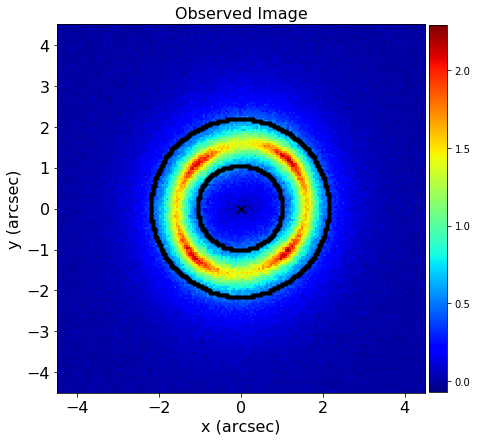

In [3]:
# Now, lets simulate the source, mask it, and use a plot to check the masking is appropriate.
image = simulate()
mask = ma.Mask.annular(shape=image.shape, pixel_scale=image.pixel_scale,
                       inner_radius_arcsec=1.0, outer_radius_arcsec=2.2)
imaging_plotters.plot_image(image=image, mask=mask)

In [4]:
# Next, lets set this image up as a lensing image, and setup a tracer using the input lens galaxy model (we don't need
# to provide the source's light profile, as we're using a mapper to reconstruct it).
lensing_image = li.LensingImage(image=image, mask=mask, sub_grid_size=1)
lens_galaxy = g.Galaxy(mass=mp.EllipticalIsothermal(centre=(0.0, 0.0), axis_ratio=0.8, phi=135.0, einstein_radius=1.6))
tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[g.Galaxy()],
                                             image_plane_grids=[lensing_image.grids])

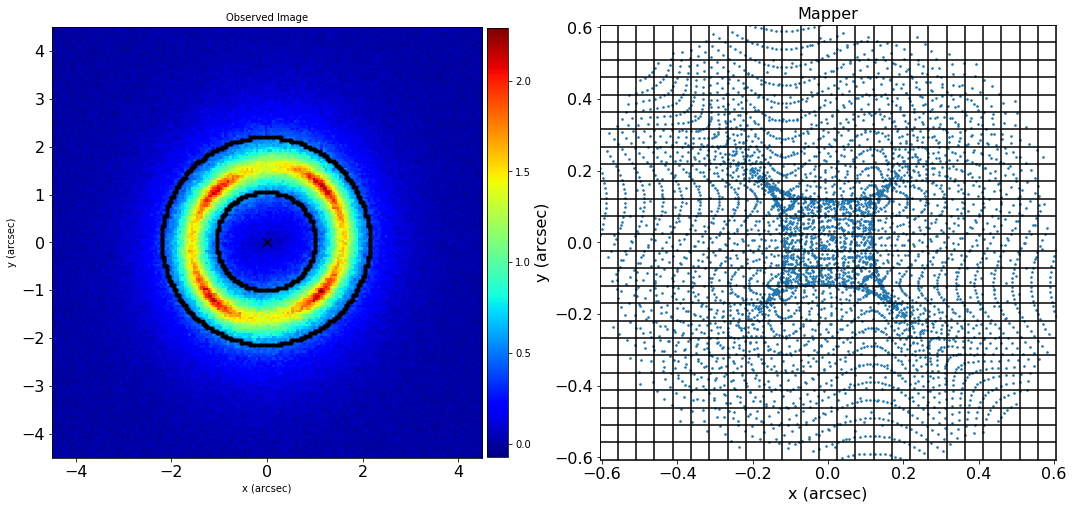

In [5]:
# We'll use another rectangular pixelization and mapper to perform the reconstruction
rectangular = pix.Rectangular(shape=(25, 25))
mapper = rectangular.mapper_from_grids_and_border(grids=tracer.source_plane.grids[0], border=None)
mapper_plotters.plot_image_and_mapper(image=image, mask=mask, mapper=mapper, should_plot_grid=True)

In [6]:
# And now, finally, we're going to use our mapper to invert the image using the 'inversions' module, which is imported
# as 'inv'. I'll explain how this works in a second - but lets just go ahead and perform the inversion first.
# (Ignore the 'regularization' input below for now, we'll cover this in the next tutorial).
inversion = inv.Inversion(image=lensing_image[:], noise_map=lensing_image.noise_map_,
                          convolver=lensing_image.convolver_mapping_matrix, mapper=mapper,
                          regularization=reg.Constant(coefficients=(1.0,)))

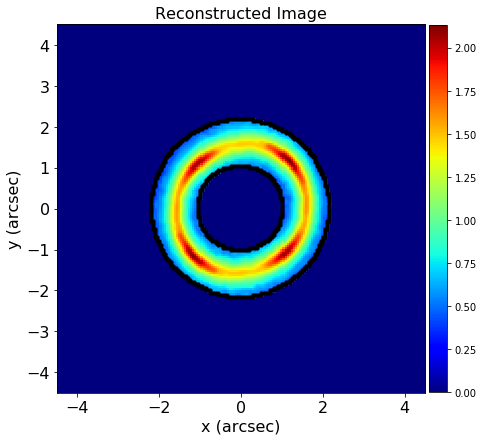

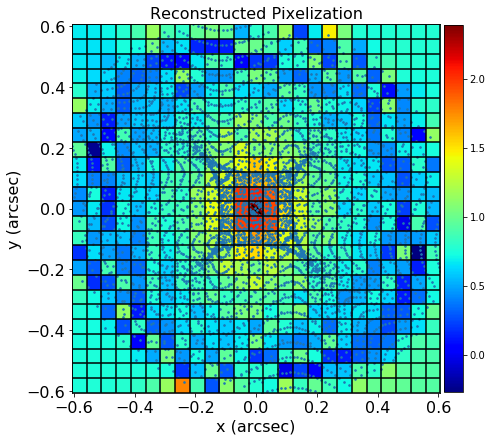

In [7]:
# Our inversion has a reconstructed image and pixeilzation, whcih we can plot using an inversion plotter
inversion_plotters.plot_reconstructed_image(inversion=inversion, mask=mask)
inversion_plotters.plot_reconstructed_pixelization(inversion=inversion, should_plot_grid=True)

In [8]:
# And there we have it, we've successfully reconstructed, or, *inverted*, our source using the mapper's rectangular
# grid. Whilst this source was simple (a blob of light in the centre of the source-plane), inversions come into their
# own when fitting sources with complex morphologies. Infact, given we're having so much fun inverting things, lets
# simulate a really complex source and invert it!

def simulate_complex_source():

    from autolens.data.array import grids
    from autolens.model.galaxy import galaxy as g
    from autolens.lensing import ray_tracing

    psf = im.PSF.simulate_as_gaussian(shape=(11, 11), sigma=0.05, pixel_scale=0.05)

    image_plane_grids = grids.DataGrids.grids_for_simulation(shape=(180, 180), pixel_scale=0.05, psf_shape=(11, 11))

    lens_galaxy = g.Galaxy(mass=mp.EllipticalIsothermal(centre=(0.0, 0.0), axis_ratio=0.8, phi=135.0,
                                                        einstein_radius=1.6))
    source_galaxy_0 = g.Galaxy(light=lp.EllipticalSersic(centre=(0.1, 0.1), axis_ratio=0.8, phi=90.0,
                                                         intensity=0.2, effective_radius=1.0, sersic_index=1.5))
    source_galaxy_1 = g.Galaxy(light=lp.EllipticalSersic(centre=(-0.25, 0.25), axis_ratio=0.7, phi=45.0,
                                                         intensity=0.1, effective_radius=0.2, sersic_index=3.0))
    source_galaxy_2 = g.Galaxy(light=lp.EllipticalSersic(centre=(0.45, -0.35), axis_ratio=0.6, phi=90.0,
                                                         intensity=0.03, effective_radius=0.3, sersic_index=3.5))
    source_galaxy_3 = g.Galaxy(light=lp.EllipticalSersic(centre=(-0.05, -0.0), axis_ratio=0.9, phi=140.0,
                                                         intensity=0.03, effective_radius=0.1, sersic_index=4.0))
    source_galaxy_4 = g.Galaxy(light=lp.EllipticalSersic(centre=(0.85, -0.85), axis_ratio=0.6, phi=90.0,
                                                         intensity=0.03, effective_radius=0.3, sersic_index=3.5))
    source_galaxy_5 = g.Galaxy(light=lp.EllipticalSersic(centre=(-0.75, -0.1), axis_ratio=0.9, phi=140.0,
                                                         intensity=0.03, effective_radius=0.1, sersic_index=4.0))

    tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy],
                                                 source_galaxies=[source_galaxy_0, source_galaxy_1, source_galaxy_2,
                                                                  source_galaxy_3, source_galaxy_4, source_galaxy_5],
                                                 image_plane_grids=[image_plane_grids])

    return im.Image.simulate(array=tracer.image_plane_image_for_simulation, pixel_scale=0.05,
                                       exposure_time=300.0, psf=psf, background_sky_level=0.1, add_noise=True)

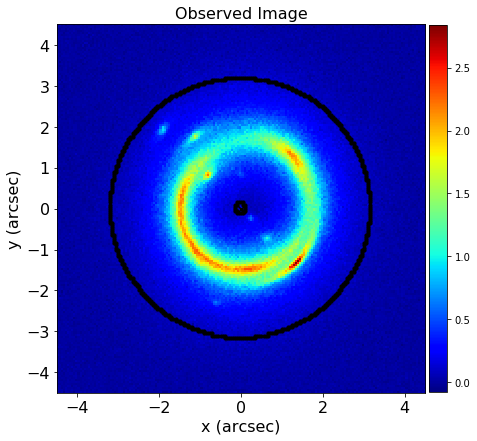

In [9]:
# This code is doing all the the same as above (setup the image, galaxies, tracer, mapper, ec.), 
# but I have made the mask slightly larger for this source.
image = simulate_complex_source()
mask = ma.Mask.annular(shape=image.shape, pixel_scale=image.pixel_scale,
                       inner_radius_arcsec=0.1, outer_radius_arcsec=3.2)
imaging_plotters.plot_image(image=image, mask=mask)
lensing_image = li.LensingImage(image=image, mask=mask, sub_grid_size=1)
tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[g.Galaxy()],
                                             image_plane_grids=[lensing_image.grids])
mapper = rectangular.mapper_from_grids_and_border(grids=tracer.source_plane.grids[0], border=None)
inversion = inv.Inversion(image=lensing_image[:], noise_map=lensing_image.noise_map_,
                          convolver=lensing_image.convolver_mapping_matrix, mapper=mapper,
                          regularization=reg.Constant(coefficients=(1.0,)))


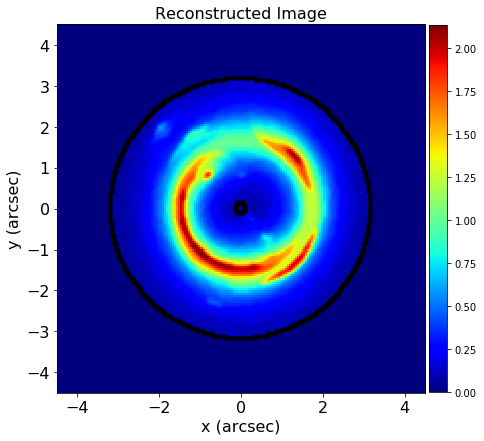

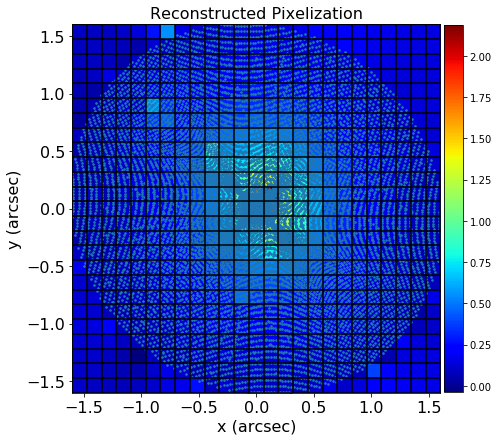

In [10]:
# Lets inspect the complex source reconstruction.
inversion_plotters.plot_reconstructed_image(inversion=inversion, mask=mask)
inversion_plotters.plot_reconstructed_pixelization(inversion=inversion, should_plot_grid=True)

In [11]:
# Pretty great, huh? If you ran the complex source pipeline, you'll remember that getting a model image that looked
# that good simply *was not possible*. With an inversion, we can do it with ease - and without 30+ parameters!

# Given that we're scientists, I guess we should think about how an inversion actually works. First, let me explain that
# the explanation I give below is overly-simplified. I'm avoiding the technical details of how an inversion *actually* 
# works. To be good at lens modeling you don't need to understand the nitty-gritty details of linear
# inversions, you just need an instinct for how to use them as a tool to model lenses.

# Nevertheless, I know a lot of you hate 'black-boxes', or have an interest in linear algrebra. If you're that way
# inclined, then checkout the documentation of the autolens source code for more information. In particular, 
# you should look at the following functions:

# inversions.mappers.mapping_matrix
# inversions.convolution.convolve_mapping_matrix
# inversions.regularization.Regularization
# inversions.inversions.Inversion

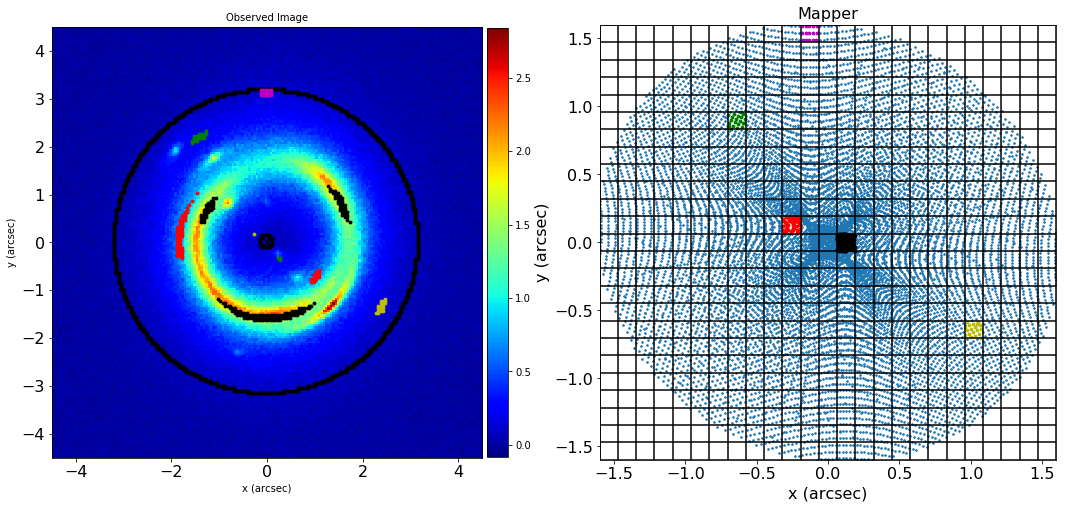

In [12]:
# To begin, lets consider some random mappings between our mapper's source-pixels and the image
mapper_plotters.plot_image_and_mapper(image=image, mapper=mapper, mask=mask, should_plot_grid=True,
                                      source_pixels=[[445], [285], [313], [132], [11]])

In [13]:
# These mappings are known before the inversion, which means pre-inversion we know two key pieces of information:

# 1) The mappings between every source-pixel and a set of image-pixels.
# 2) The flux values in every observed image-pixel, which are the values we want to fit successfully.

# It turns out that with these two pieces of information we can linearly solve for the set of source-pixel fluxes that
# best-fit (e.g. maximize the likelihood of) our observed image. Essentially, we set up the mapping between source and
# image pixels as a large matrix, and solve for the source-pixel fluxes in an analogous fashion to how you would
# solve a set of simultaneous linear equations. This process is called a 'linear inversion'.

# There are three more things about a linear inversion that are worth knowing:

# 1) We've discussed the image sub-grid before, which splits each image-pixel into a sub-pixel. If a sub-grid is used,
#    it is the mapping between every sub-pixel and source-pixel that is computed and used to perform the inversion.
#    This prevents aliasing effects degrading the image reconstruction, and, as a rule of thumb, I would
#    suggest you use sub-gridding of degree 2x2.

# 2) When fitting image's using light profiles, we discussed how a 'model_image' was generated by blurring them with
#    the instrument's PSF. A similar blurring operation is incorporated into the inversion, such that the reconstructed
#    image and source fully account for the telescope optics and effect of the PSF.

# 3) The inversion's solution is regularized. But wait, that's what we'll cover in the next tutorial!

In [14]:
# Finally, let me show you how easy it is to fit an image with an inversion using the fitting module. Instead of giving
# the source galaxy a light profile, we give it a pixelization and regularization, and pass it to a tracer.
source_galaxy = g.Galaxy(pixelization=pix.Rectangular(shape=(40, 40)), regularization=reg.Constant(coefficients=(1.0,)))
tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy],
                                             image_plane_grids=[lensing_image.grids], border=lensing_image.border)

In [15]:
# Then, like before, we call on the fitting module to perform the fit to the lensing image. Indeed, we see
# some pretty good looking residuals - we're certainly fitting the lensed source accurately!
fit = lensing_fitting.fit_lensing_image_with_tracer(lensing_image=lensing_image, tracer=tracer)
lensing_fitting_plotters.plot_fitting_subplot(fit=fit)

NoSectionError: No section: 'output'

In [ ]:
# And, we're done, here are a few questions to get you thinking about inversions:

# 1) The inversion provides the best-fit solution to the observed image. Is there a problem with seeking the 'best-fit'?
#    Is there a risk that we're going to fit other things in the image than just the lensed source galaxy? What happens
#    if you reduce the regularization 'coefficient' above to zero?

# 2) The exterior pixels in the rectangular grid have no image-pixels in them. However, they are still given a
#    reconstructed flux. If this value isn't' coming from a mapping to an image-pixel, where is it be coming from?
